# <h1 align="center"><font color = #0081be>Lighthouse - Desafio DS</font></h1>

## <a><font color = #0081be>**Objetivos**</font></a>
A empresa Adventure Works (AW) é uma indústria de bicicletas com mais de 500 produtos distintos, 20.000 clientes e 31.000 pedidos. Nesse desafio, será realizada uma previsão de demanda, a fim, de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima.

> <a><font color = #0081be>**1.**</font></a> A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.

>  <a><font color = #0081be>**2.**</font></a> Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.
   
> <a><font color = #0081be>**3.**</font></a> Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 1?
   
> <a><font color = #0081be>**4.**</font></a> Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?

### Todas as bibliotecas que serão utilizadas neste processo

In [ ]:
!pip install hierarchicalforecast

In [ ]:
!pip install statsforecast

  Using cached statsforecast-1.7.3-py3-none-any.whl (120 kB)
  Using cached fugue-0.8.7-py3-none-any.whl (279 kB)
  Using cached utilsforecast-0.1.1-py3-none-any.whl (40 kB)
  Using cached triad-0.9.5-py3-none-any.whl (61 kB)
  Using cached adagio-0.2.4-py3-none-any.whl (26 kB)
  Using cached qpd-0.4.4-py3-none-any.whl (169 kB)
  Using cached fugue_sql_antlr-0.2.0-py3-none-any.whl
  Using cached antlr4_python3_runtime-4.11.1-py3-none-any.whl (144 kB)
  Using cached fs-2.4.16-py2.py3-none-any.whl (135 kB)


In [ ]:
!pip install google-cloud-bigquery

In [ ]:
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsforecast as sf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from hierarchicalforecast.evaluation import HierarchicalEvaluation, mse
import numpy as np
from hierarchicalforecast.evaluation import HierarchicalEvaluation, mse
from hierarchicalforecast.utils import aggregate

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Conexão com o Google BigQuery

In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
project_id = 'desafioawd'
client = bigquery.Client(project=project_id)

### Escolhendo as tabelas que serão usadas para as análises

In [ ]:
query = client.query(f"select * from desafioawd.dbt_nsilva_marts.dim_products ")
df_products = query.to_dataframe()

query = client.query(f"select * from desafioawd.dbt_nsilva_marts.dim_employee ")
df_employee =query.to_dataframe()

query = client.query(f"select * from desafioawd.dbt_nsilva_marts.fct_order_detail ")
df_detail =query.to_dataframe()

query = client.query(f"select * from desafioawd.dbt_nsilva_marts.fct_order_header ")
df_header =query.to_dataframe()

query = client.query(f"select * from desafioawd.dbt_nsilva_marts.dim_customer ")
df_customer =query.to_dataframe()

### Criando os joins

In [ ]:
df_header['territory_id'] = df_header['territory_id'].astype(int)
df_customer['customer_id'] = df_customer['customer_id'].astype(int)

In [ ]:
df_product_detail = pd.merge (df_products , df_detail, on = 'product_id', how = 'right')
df_header_employee = pd.merge (df_header , df_employee, left_on = 'territory_id', right_on = 'territoryid')
df_4 = pd.merge (df_product_detail , df_header_employee, on = 'sales_order_id')
df_4['customer_id_x'] = df_4['customer_id_x'].astype(int)
df_ds = pd.merge(df_4,df_customer, left_on='customer_id_x', right_on='customer_id', how='left')
display(df_ds)


,product_sk,product_id,product_name,average_ticket,territory_fk_x,seller_id_x,sales_order_fk,product_fk,sales_order_detail_id,sales_order_id,...,saleslastyear,customer_sk,customer_id,person_id,persontype,first_name,middle_name,last_name,full_name_y,store_id
0,67d96d458abdef21792e6d8e590244e7,779,"Mountain-200 Silver, 38",1544.062854,0c6067e0417d32f71a6a15556ee5d6c6,None,0c94f34f6c2f2b4a74c55239313625e1,67d96d458abdef21792e6d8e590244e7,18089,47477,...,2.396540e+06,0c6067e0417d32f71a6a15556ee5d6c6,28560,1768,IN,Peggy,R.,Smith,Peggy R. Smith,None
1,82489c9737cc245530c7a6ebef3753ec,794,"Road-250 Black, 48",1567.587512,3b745f046957f6b3ea1b037370023dc4,None,dcebacc996ed40656c7097704c600386,82489c9737cc245530c7a6ebef3753ec,18257,47645,...,2.396540e+06,3b745f046957f6b3ea1b037370023dc4,14555,4699,IN,Jodi,D,Kumar,Jodi D Kumar,None
2,da8ce53cf0240070ce6c69c48cd588ee,793,"Road-250 Black, 44",1533.678297,c1f901ce2fdfc413658ecf4326d42b57,None,44d0ec38e6c6b6f1587ec29372ae6aa1,da8ce53cf0240070ce6c69c48cd588ee,19745,47800,...,2.396540e+06,c1f901ce2fdfc413658ecf4326d42b57,14798,12339,IN,Colleen,L,Nara,Colleen L Nara,None
3,2dace78f80bc92e6d7493423d729448e,790,"Road-250 Red, 48",1661.417819,e608961813ac47bc0cfbcac85dd2147f,None,4c4d7d721cf9a48f1edb88443bd1e863,2dace78f80bc92e6d7493423d729448e,30763,50054,...,2.396540e+06,e608961813ac47bc0cfbcac85dd2147f,16412,17470,IN,Leah,None,Liang,Leah Liang,None
4,fc8001f834f6a5f0561080d134d53d29,784,"Mountain-200 Black, 46",1568.497602,2f64bf56821bc84ff5418577e2dc48d9,None,6f56fe4f5c645fcd570aa5c5c7dd55da,fc8001f834f6a5f0561080d134d53d29,33324,50443,...,2.396540e+06,2f64bf56821bc84ff5418577e2dc48d9,11416,16361,IN,Katrina,None,Becker,Katrina Becker,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199750,c4015b7f368e6b4871809f49debe0579,923,Touring Tire Tube,4.990000,e2b78d72a53028927d9d40b3daacdf40,None,cdeca3f5bffa36c8fa08e83a1c3cb0b8,c4015b7f368e6b4871809f49debe0579,117144,73373,...,2.396540e+06,e2b78d72a53028927d9d40b3daacdf40,27335,17029,IN,Ricardo,None,Raji,Ricardo Raji,None
199751,ae0eb3eed39d2bcef4622b2499a05fe6,708,"Sport-100 Helmet, Black",24.812723,26c79831bb09706f44a4e975518b1997,None,ddf3c2cf55d781a645117700952a1a4e,ae0eb3eed39d2bcef4622b2499a05fe6,120580,74806,...,2.396540e+06,26c79831bb09706f44a4e975518b1997,19063,3325,IN,Gabrielle,None,Kelly,Gabrielle Kelly,None
199752,d045c59a90d7587d8d671b5f5aec4e7c,928,LL Mountain Tire,24.990000,26c79831bb09706f44a4e975518b1997,None,ddf3c2cf55d781a645117700952a1a4e,d045c59a90d7587d8d671b5f5aec4e7c,120578,74806,...,2.396540e+06,26c79831bb09706f44a4e975518b1997,19063,3325,IN,Gabrielle,None,Kelly,Gabrielle Kelly,None
199753,430c3626b879b4005d41b8a46172e0c0,921,Mountain Tire Tube,4.990000,26c79831bb09706f44a4e975518b1997,None,ddf3c2cf55d781a645117700952a1a4e,430c3626b879b4005d41b8a46172e0c0,120579,74806,...,2.396540e+06,26c79831bb09706f44a4e975518b1997,19063,3325,IN,Gabrielle,None,Kelly,Gabrielle Kelly,None


In [ ]:
display(df_ds.columns)

Index(['product_sk', 'product_id', 'product_name', 'average_ticket',
       'territory_fk_x', 'seller_id_x', 'sales_order_fk', 'product_fk',
       'sales_order_detail_id', 'sales_order_id', 'order_qty', 'unit_price',
       'sub_total', 'order_date_x', 'customer_id_x', 'territory_id_x',
       'full_address_x', 'customer_fk', 'territory_fk_y', 'credit_card_fk',
       'sales_person_id', 'order_date_y', 'customer_id_y', 'credit_card_id',
       'total_due', 'status', 'territory_id_y', 'full_address_y',
       'seller_id_y', 'full_name_x', 'jobtitle', 'hiredate', 'territoryid',
       'territory_name', 'countryregioncode', 'territory_group', 'salesquota',
       'bonus', 'commissionpct', 'salesytd', 'saleslastyear', 'customer_sk',
       'customer_id', 'person_id', 'persontype', 'first_name', 'middle_name',
       'last_name', 'full_name_y', 'store_id'],
      dtype='object')

In [ ]:
colunas_a_apagar = ['product_sk', 'product_id', 'average_ticket',
       'territory_fk_x', 'seller_id_x', 'sales_order_fk', 'product_fk',
       'sales_order_detail_id', 'sales_order_id', 'unit_price',
       'sub_total', 'order_date_x', 'customer_id_x', 'territory_id_x',
       'full_address_x', 'customer_fk', 'territory_fk_y', 'credit_card_fk',
       'sales_person_id',  'customer_id_y', 'credit_card_id',
       'total_due', 'status', 'territory_id_y', 'full_address_y',
       'seller_id_y', 'full_name_x', 'jobtitle', 'hiredate',
       'territoryid', 'countryregioncode', 'territory_group', 'salesquota',
       'bonus', 'commissionpct', 'salesytd', 'saleslastyear', 'customer_sk',
       'customer_id', 'person_id', 'persontype', 'first_name', 'middle_name',
       'last_name', 'full_name_y']

df_ds2 = df_ds.drop(columns=colunas_a_apagar)
display(df_ds2)

,product_name,order_qty,order_date_y,territory_name,store_id
0,"Mountain-200 Silver, 38",1,2012-08-03 00:00:00.000,France,None
1,"Road-250 Black, 48",1,2012-08-28 00:00:00.000,France,None
2,"Road-250 Black, 44",1,2012-09-10 00:00:00.000,France,None
3,"Road-250 Red, 48",1,2013-03-16 00:00:00.000,France,None
4,"Mountain-200 Black, 46",1,2013-04-09 00:00:00.000,France,None
...,...,...,...,...,...
199750,Touring Tire Tube,1,2014-05-20 00:00:00.000,France,None
199751,"Sport-100 Helmet, Black",1,2014-06-20 00:00:00.000,France,None
199752,LL Mountain Tire,1,2014-06-20 00:00:00.000,France,None
199753,Mountain Tire Tube,1,2014-06-20 00:00:00.000,France,None


In [ ]:
#Transformando a coluna de data em uma coluna de data mesmo:
df_ds2['order_date_y'] = pd.to_datetime(df_ds2['order_date_y'])
#Criando uma coluna pro mês, pra gente agrupar por mês
df_ds2['month'] = df_ds2['order_date_y'].dt.to_period('M')


agg_functions = {
    'order_qty': 'sum',
    'territory_name': 'first',
	'order_date_y':'first'
}

df_ds3 = df_ds2.groupby(['product_name', 'store_id', 'month'], as_index=False).agg(agg_functions).reset_index()
display(df_ds3)

,index,product_name,store_id,month,order_qty,territory_name,order_date_y
0,0,AWC Logo Cap,1002,2012-05,4,Southwest,2012-05-30
1,1,AWC Logo Cap,1002,2012-08,4,Southwest,2012-08-30
2,2,AWC Logo Cap,1002,2013-05,8,Southwest,2013-05-30
3,3,AWC Logo Cap,1002,2013-08,10,Southwest,2013-08-30
4,4,AWC Logo Cap,1002,2014-03,6,Southwest,2014-03-01
...,...,...,...,...,...,...,...
60895,60895,"Women's Tights, S",982,2012-08,4,France,2012-08-30
60896,60896,"Women's Tights, S",982,2012-11,5,France,2012-11-30
60897,60897,"Women's Tights, S",982,2013-02,3,France,2013-02-28
60898,60898,"Women's Tights, S",986,2012-06,12,Canada,2012-06-30


### Começando a responder as perguntas de negócio

In [ ]:
print(f"Quantidade de lojas: {df_ds3['store_id'].nunique()}")
print(f"Quantidade de produtos: {df_ds3['product_name'].nunique()}")
quantidade_pares_distintos = len(df_ds3[['store_id', 'product_name']].drop_duplicates())
print(f"A quantidade de pares distintos store_id X product_name é: {quantidade_pares_distintos}")

Quantidade de lojas: 635
Quantidade de produtos: 250
A quantidade de pares distintos store_id X product_name é: 20511


### Registros dos pares produto X loja que tenham mais que 5 vendas em meses distintos

In [ ]:
result_ds = df_ds3.groupby(['product_name', 'store_id'])['month'].nunique().reset_index()

result_ds.columns = ['product_name', 'store_id', 'distinct_month_count']

print(result_ds[result_ds['distinct_month_count']>5])

                product_name store_id  distinct_month_count
5               AWC Logo Cap     1018                     7
14              AWC Logo Cap     1046                    12
20              AWC Logo Cap     1086                    12
26              AWC Logo Cap     1132                     6
27              AWC Logo Cap     1134                     6
...                      ...      ...                   ...
18017  Sport-100 Helmet, Red      828                    12
18019  Sport-100 Helmet, Red      852                     7
18023  Sport-100 Helmet, Red      874                     8
18030  Sport-100 Helmet, Red      954                     8
18035  Sport-100 Helmet, Red      982                     8

[1724 rows x 3 columns]


In [ ]:
agg_functions = {'store_id': 'first'}  # Definindo a função de agregação
grouped_by_product = df_ds3.groupby(['product_name', 'month'], as_index=False).agg(agg_functions).reset_index()  # Agrupando e agregando os dados
productid_counts = grouped_by_product['product_name'].value_counts()  # Contando os valores de productid
print(productid_counts)  # Imprimindo os resultados

Sport-100 Helmet, Blue              34
AWC Logo Cap                        32
LL Road Frame - Black, 58           32
Long-Sleeve Logo Jersey, XL         32
HL Mountain Frame - Silver, 38      32
                                    ..
Classic Vest, L                      2
LL Road Seat/Saddle                  2
ML Mountain Frame-W - Silver, 38     2
LL Mountain Frame - Black, 52        2
LL Touring Frame - Blue, 58          1
Name: product_name, Length: 250, dtype: int64


In [ ]:
agg_functions = {
    'order_date_y': 'first',
    'order_qty': 'sum',
    }

grouped_by_product = df_ds3.groupby(['product_name', 'month', 'store_id',]).agg(agg_functions).reset_index()

In [ ]:
print(grouped_by_product.columns)

Index(['product_name', 'month', 'store_id', 'order_date_y', 'order_qty'], dtype='object')


### Criação de um dataframe para um dos produtos com mais meses de venda

In [ ]:

test = grouped_by_product[grouped_by_product['product_name'] == "LL Road Frame - Black, 58" ][['month', 'order_date_y', 'order_qty', 'product_name']]

grouped_test = test.groupby('month').agg({'order_qty': 'sum', 'order_date_y': 'first', 'product_name': 'first'}).reset_index()

display(grouped_test)

,month,order_qty,order_date_y,product_name
0,2011-05,16,2011-05-31,"LL Road Frame - Black, 58"
1,2011-07,34,2011-07-01,"LL Road Frame - Black, 58"
2,2011-08,42,2011-08-31,"LL Road Frame - Black, 58"
3,2011-10,91,2011-10-01,"LL Road Frame - Black, 58"
4,2011-12,7,2011-12-01,"LL Road Frame - Black, 58"
5,2012-01,17,2012-01-01,"LL Road Frame - Black, 58"
6,2012-02,34,2012-02-29,"LL Road Frame - Black, 58"
7,2012-03,42,2012-03-30,"LL Road Frame - Black, 58"
8,2012-04,40,2012-04-30,"LL Road Frame - Black, 58"
9,2012-05,71,2012-05-30,"LL Road Frame - Black, 58"


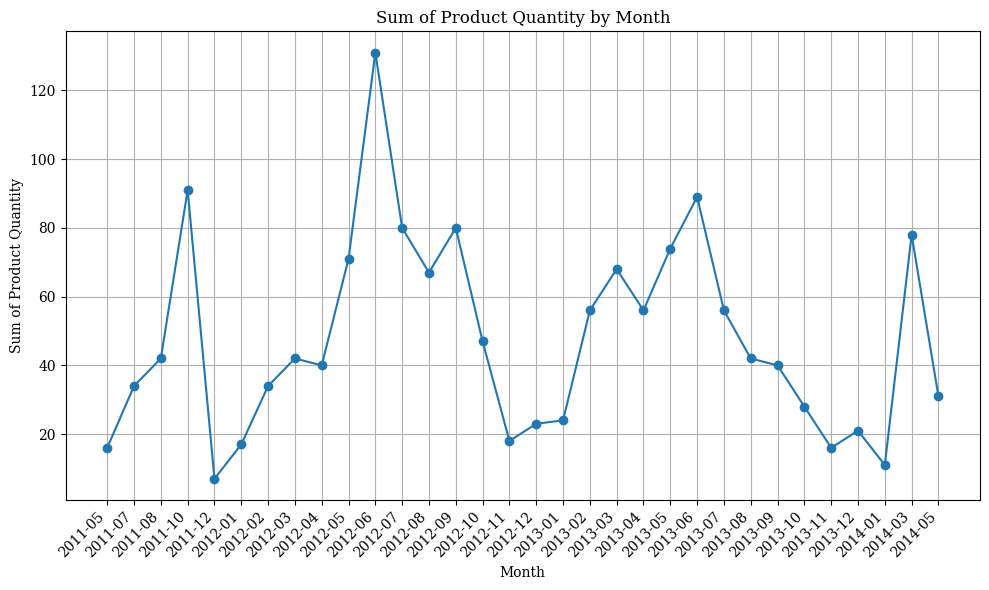

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(grouped_test['month'].astype(str), grouped_test['order_qty'], marker='o')
plt.xlabel('Month')
plt.ylabel('Sum of Product Quantity')
plt.title('Sum of Product Quantity by Month')
plt.xticks(rotation=45, ha="right")
plt.grid(True)  # Adicionando grades para facilitar a leitura
plt.tight_layout()
plt.show()

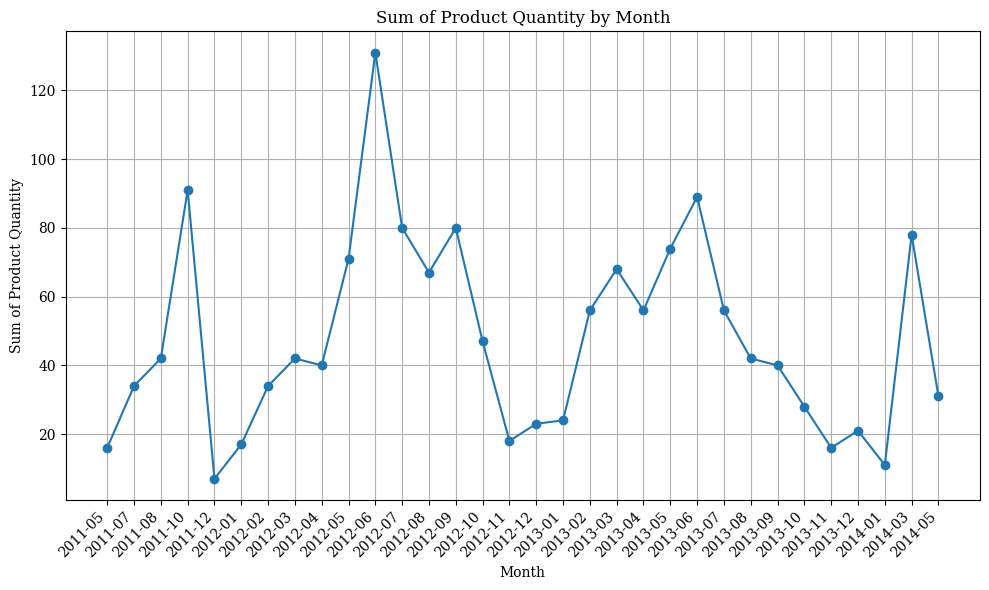

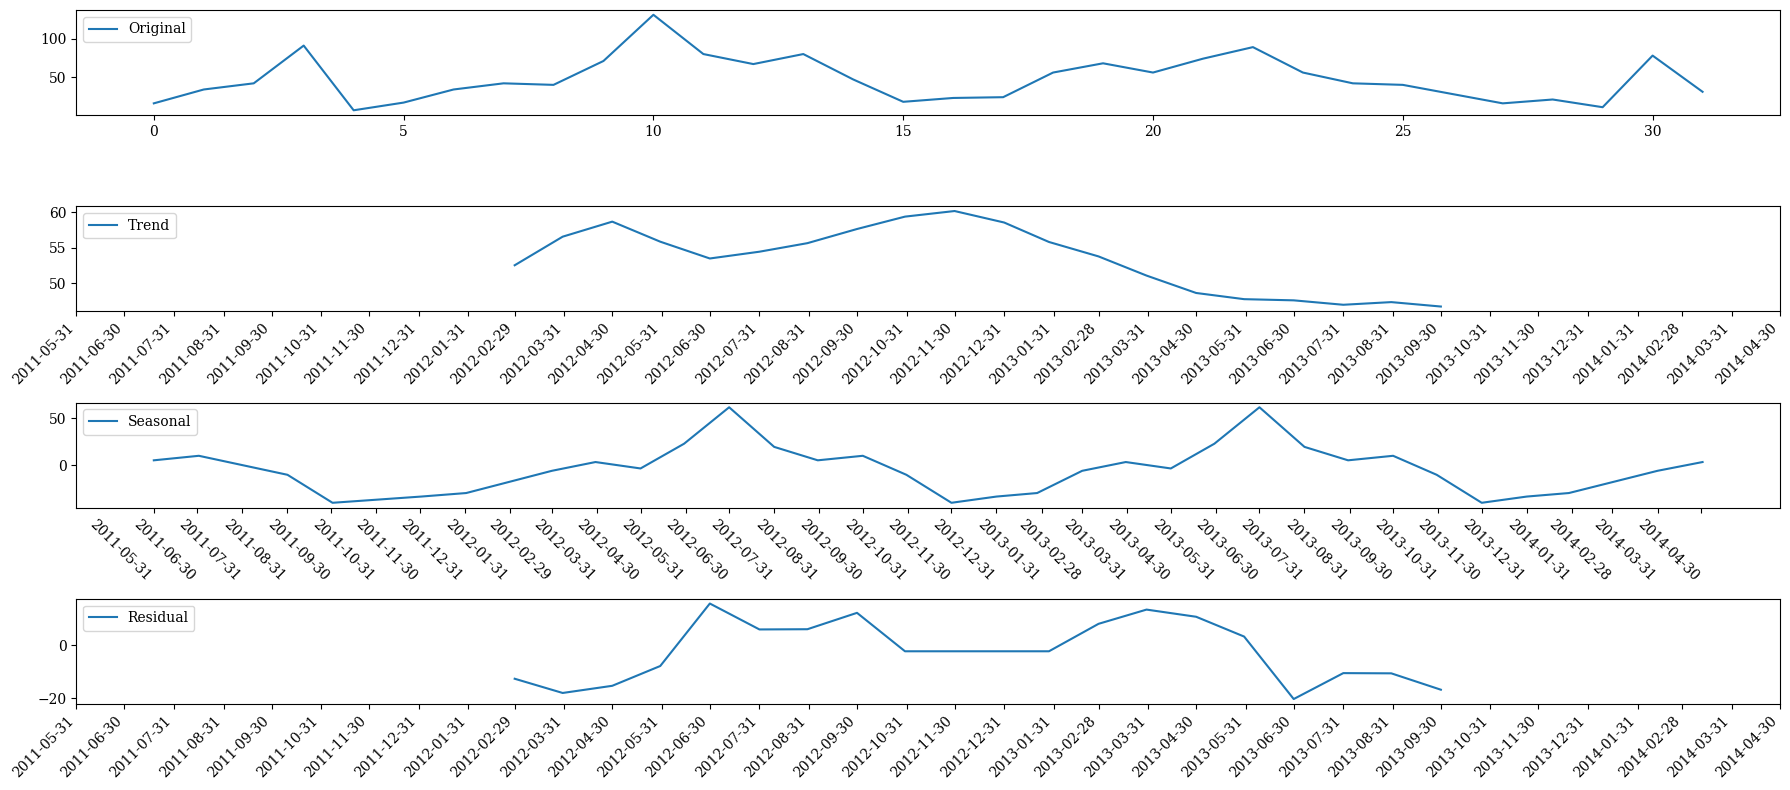

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(grouped_test['month'].astype(str), grouped_test['order_qty'], marker='o')
plt.xlabel('Month')
plt.ylabel('Sum of Product Quantity')
plt.title('Sum of Product Quantity by Month')
plt.xticks(rotation=45, ha="right")
plt.grid(True)  # Adicionando grades para facilitar a leitura
plt.tight_layout()
plt.show()

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition: DecomposeResult):
    plt.figure(figsize=(18,8))

    plt.subplot(4,1,1)
    plt.plot(data['order_qty'], label="Original")
    plt.legend(loc='upper left')

    plt.subplot(4,1,2)
    plt.plot(seasonal_decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.xticks(pd.date_range(data['order_date_y'].min(), data['order_date_y'].max(), freq='M'))

    plt.subplot(4,1,3)
    plt.plot(seasonal_decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.xticks(rotation=-45, ha="right")
    plt.xticks(pd.date_range(data['order_date_y'].min(), data['order_date_y'].max(), freq='M'))

    plt.subplot(4,1,4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.xticks(pd.date_range(data['order_date_y'].min(), data['order_date_y'].max(), freq='M'))

    plt.tight_layout()
    plt.show()

result = seasonal_decompose(grouped_test.set_index('order_date_y')['order_qty'], model='additive', period=12)
seasonal_decomposition_plots(data=grouped_test, seasonal_decomposition=result)

- A sazonalidade é um padrão que se repete em intervalos regulares de tempo. No caso do nosso caso, a sazonalidade é representada pela linha azul que sobe e desce em intervalos regulares ao longo de quatro anos (de 2010 a 2014).

- Os picos visíveis no gráfico que ocorrem em intervalos regulares mostram que há períodos específicos durante o ano em que a demanda pelo produto "LL Road Frame - Black, 58" aumenta.

- Entender a sazonalidade pode ser muito útil para a gestão de negócios. Por exemplo, pode ajudar a informar decisões sobre quando aumentar a produção, quando realizar vendas ou promoções, e quando é melhor realizar manutenção ou atualizações.

### Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação

Estamos lidando com um problema de série temporal, pois as vendas dos produtos variam ao longo do tempo e podem ser influenciadas por fatores como sazonalidade. Além disso, a quantidade vendida em um mês pode afetar as vendas do mês seguinte. Ao dividir o problema por produto e loja, criamos uma série hierárquica. No entanto, temos poucos registros para cada série temporal, já que cada combinação de produto e loja tem, no máximo, 36 meses de vendas (que é a duração do nosso banco de dados). Prever algo com apenas 36 pontos de dados é um desafio. Por isso, uma alternativa seria tratar isso como um problema de regressão. Nesse caso, tentaríamos prever as vendas de um produto com base em variáveis como o preço do produto, a localização da loja, o tamanho da loja, a quantidade de funcionários da loja, o tamanho do produto, a qualidade do produto, se é manufaturado ou não, entre outros. No modelo de regressão, também poderíamos incluir as vendas dos meses anteriores como novas colunas. Assim, nosso dataframe seria algo como:

- Em vez de ter as colunas: produto | loja | data | quantidade vendida

- Teríamos as colunas: produto | loja | quantidade vendida no mês 1 | quantidade vendida no mês 2 | quantidade vendida no mês 3 |

Dessa forma, poderíamos usar um modelo de regressão para resolver um problema de série temporal. Esse modelo de regressão provavelmente teria um bom desempenho nos primeiros meses, mas seria menos preciso para prever vendas em um horizonte de tempo mais longo (como um ano à frente). No entanto, o mesmo pode ser dito para o modelo de séries temporais hierárquicas.

Então sim, seria possível resolver este problema usando uma abordagem de modelos de regressão. Quanto a qual abordagem apresenta melhores resultados, isso dependeria das métricas de avaliação específicas utilizadas. Por exemplo, poderíamos usar o erro quadrático médio (MSE) ou o coeficiente de determinação (R²) para comparar os modelos. No entanto, é importante lembrar que cada modelo tem suas próprias forças e limitações, e a escolha do modelo deve ser baseada no contexto específico do problema.

 ### Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 1?

In [ ]:
agrupado = df_ds3.groupby(['product_name', 'store_id']).agg({'month': pd.Series.nunique}).reset_index()
pares_filtrados = agrupado[agrupado['month'] >= 5]

df_ds4 = df_ds3.merge(pares_filtrados[['product_name', 'store_id']], on=['product_name', 'store_id'], how='inner')
display(df_ds4)

,index,product_name,store_id,month,order_qty,territory_name,order_date_y
0,0,AWC Logo Cap,1002,2012-05,4,Southwest,2012-05-30
1,1,AWC Logo Cap,1002,2012-08,4,Southwest,2012-08-30
2,2,AWC Logo Cap,1002,2013-05,8,Southwest,2013-05-30
3,3,AWC Logo Cap,1002,2013-08,10,Southwest,2013-08-30
4,4,AWC Logo Cap,1002,2014-03,6,Southwest,2014-03-01
...,...,...,...,...,...,...,...
14701,53917,"Sport-100 Helmet, Red",982,2013-02,2,France,2013-02-28
14702,53918,"Sport-100 Helmet, Red",982,2013-05,16,France,2013-05-30
14703,53919,"Sport-100 Helmet, Red",982,2013-08,7,France,2013-08-30
14704,53920,"Sport-100 Helmet, Red",982,2013-11,4,France,2013-11-30


In [ ]:
general_hierarchies = [
    ['territory_name'],
    ['territory_name','store_id'],
    ['territory_name', 'store_id','product_name']
]

In [ ]:
hts = (
    df_ds4
    .groupby(["month", "product_name", "store_id", "territory_name"])["order_qty"].sum()
    .reset_index()
    .rename(columns={"month": "ds", "order_qty": "y"})
)

In [ ]:
display(hts)

,ds,product_name,store_id,territory_name,y
0,2011-05,AWC Logo Cap,1046,Southeast,2
1,2011-05,AWC Logo Cap,1086,Northeast,1
2,2011-05,AWC Logo Cap,1184,Southwest,6
3,2011-05,AWC Logo Cap,1414,Southwest,12
4,2011-05,AWC Logo Cap,302,Southwest,6
...,...,...,...,...,...
14701,2014-05,"Sport-100 Helmet, Red",432,United Kingdom,3
14702,2014-05,"Sport-100 Helmet, Red",516,Central,10
14703,2014-05,"Sport-100 Helmet, Red",642,Southwest,14
14704,2014-05,"Sport-100 Helmet, Red",798,Southeast,8


In [ ]:
hts['ds'] = hts['ds'].dt.to_timestamp(how='start').dt.date

In [ ]:
Y_df, S_df, tags = aggregate(hts, general_hierarchies)
Y_df = Y_df.reset_index()
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
display(Y_df)

,unique_id,ds,y
0,Canada,2011-05-01,270
1,Canada,2011-07-01,332
2,Canada,2011-08-01,604
3,Canada,2011-10-01,768
4,Canada,2011-12-01,228
...,...,...,...
16455,"United Kingdom/602/Sport-100 Helmet, Red",2012-09-01,2
16456,"United Kingdom/602/Sport-100 Helmet, Red",2013-03-01,8
16457,"United Kingdom/602/Sport-100 Helmet, Red",2013-06-01,2
16458,"United Kingdom/602/Sport-100 Helmet, Red",2013-09-01,2


In [ ]:
# Preenchimento das demais datas com 0 vendas:
from datetime import datetime, timedelta
unique_ids = Y_df['unique_id'].unique()
start_date = Y_df['ds'].min()
end_date = Y_df['ds'].max()

#Criando um dataframe com todas as combinações unique_id e ds possíveis:
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
all_combinations = pd.DataFrame([(unique_id, date) for unique_id in unique_ids for date in date_range],
                                columns=['unique_id', 'ds'])

#Juntando esse dataframe com o dataframe original
complete_df = pd.merge(all_combinations, Y_df, on=['unique_id', 'ds'], how='left')

#Preenchendo com "0" os meses sem venda
complete_df['y'] = complete_df['y'].fillna(0)

display(complete_df)

,unique_id,ds,y
0,Canada,2011-05-01,270
1,Canada,2011-06-01,0
2,Canada,2011-07-01,332
3,Canada,2011-08-01,604
4,Canada,2011-09-01,0
...,...,...,...
85724,"United Kingdom/602/Sport-100 Helmet, Red",2014-01-01,0
85725,"United Kingdom/602/Sport-100 Helmet, Red",2014-02-01,0
85726,"United Kingdom/602/Sport-100 Helmet, Red",2014-03-01,6
85727,"United Kingdom/602/Sport-100 Helmet, Red",2014-04-01,0


In [ ]:
Y_test_df  = complete_df.groupby('unique_id').tail(3)
Y_train_df = complete_df.drop(Y_test_df.index)

display(Y_train_df.shape)
display(Y_test_df.shape)

(78778, 3)

(6951, 3)

In [ ]:
Y_test_df = Y_test_df.set_index('unique_id')

In [ ]:
fcst = StatsForecast(df=Y_train_df,
                     models=[AutoARIMA(season_length=12), Naive()],
                     freq='M', n_jobs=-1)
Y_hat_train = fcst.forecast(h=3)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [33]:
total_hat = fcst.forecast(df=Y_df, h=3)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [34]:
lista_territorios = df_ds4['territory_name'].unique()
display(lista_territorios)

array(['Southwest', 'Northwest', 'Southeast', 'Northeast', 'France',
       'Canada', 'Central', 'United Kingdom'], dtype=object)

In [35]:
display(total_hat)

,ds,AutoARIMA,Naive
unique_id,,,
Canada,2014-05-31,802.706238,688.0
Canada,2014-06-30,785.475952,688.0
Canada,2014-07-31,768.615540,688.0
Canada/1040,2014-05-31,30.798500,32.0
Canada/1040,2014-06-30,29.642115,32.0
...,...,...,...
"United Kingdom/602/Sport-100 Helmet, Blue",2014-04-30,3.138032,4.0
"United Kingdom/602/Sport-100 Helmet, Blue",2014-05-31,2.779432,4.0
"United Kingdom/602/Sport-100 Helmet, Red",2014-03-31,0.000000,6.0


In [38]:
territorio_hat = total_hat[total_hat.index.isin(lista_territorios)]

In [39]:
display(territorio_hat)

,ds,AutoARIMA,Naive
unique_id,,,
Canada,2014-05-31,802.706238,688.0
Canada,2014-06-30,785.475952,688.0
Canada,2014-07-31,768.615540,688.0
Central,2014-05-31,240.459641,185.0
Central,2014-06-30,240.459641,185.0
Central,2014-07-31,240.459641,185.0
France,2014-05-31,141.280319,62.0
France,2014-06-30,141.280289,62.0
France,2014-07-31,141.280273,62.0


O "AutoARIMA" é o modelo que usamos e "Naive" é um modelo que dá o valor do último mês, só pra comparação. Sendo assim, tivemos um aumento em:
- Northwest
- Southwest

### Previsão de Demanda das Luvas
- Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?

In [46]:
#Listando todos os produtos com "luvas" no nome
luvas_hat = total_hat[total_hat.index.str.contains('Gloves')]
display(luvas_hat)


,ds,AutoARIMA,Naive
unique_id,,,
"Canada/1200/Half-Finger Gloves, M",2014-03-31,4.418098,6.0
"Canada/1200/Half-Finger Gloves, M",2014-04-30,3.253265,6.0
"Canada/1200/Half-Finger Gloves, M",2014-05-31,2.395540,6.0
"Canada/1322/Half-Finger Gloves, L",2014-05-31,0.000000,4.0
"Canada/1322/Half-Finger Gloves, L",2014-06-30,0.000000,4.0
...,...,...,...
"United Kingdom/534/Half-Finger Gloves, M",2014-04-30,3.934005,8.0
"United Kingdom/534/Half-Finger Gloves, M",2014-05-31,2.758718,8.0
"United Kingdom/534/Half-Finger Gloves, S",2014-03-31,6.142864,7.0


In [50]:
display(df_ds4[df_ds4['product_name'].str.contains('Gloves')]['product_name'].unique())

array(['Half-Finger Gloves, L', 'Half-Finger Gloves, M',
       'Half-Finger Gloves, S'], dtype=object)

In [51]:
#Tamanho L
luvas_hat_L = luvas_hat[luvas_hat.index.str.contains('Half-Finger Gloves, L')]
display(luvas_hat_L)

,ds,AutoARIMA,Naive
unique_id,,,
"Canada/1322/Half-Finger Gloves, L",2014-05-31,0.000000,4.0
"Canada/1322/Half-Finger Gloves, L",2014-06-30,0.000000,4.0
"Canada/1322/Half-Finger Gloves, L",2014-07-31,0.000000,4.0
"Canada/622/Half-Finger Gloves, L",2014-03-31,0.000000,14.0
"Canada/622/Half-Finger Gloves, L",2014-04-30,0.000000,14.0
"Canada/622/Half-Finger Gloves, L",2014-05-31,0.000000,14.0
"Canada/794/Half-Finger Gloves, L",2014-03-31,0.000000,10.0
"Canada/794/Half-Finger Gloves, L",2014-04-30,0.000000,10.0
"Canada/794/Half-Finger Gloves, L",2014-05-31,0.000000,10.0


In [52]:
#Tamanho M
luvas_hat_M = luvas_hat[luvas_hat.index.str.contains('Half-Finger Gloves, M')]
display(luvas_hat_M)

,ds,AutoARIMA,Naive
unique_id,,,
"Canada/1200/Half-Finger Gloves, M",2014-03-31,4.418098,6.0
"Canada/1200/Half-Finger Gloves, M",2014-04-30,3.253265,6.0
"Canada/1200/Half-Finger Gloves, M",2014-05-31,2.395540,6.0
"Canada/1322/Half-Finger Gloves, M",2014-05-31,20.000000,20.0
"Canada/1322/Half-Finger Gloves, M",2014-06-30,20.000000,20.0
...,...,...,...
"United Kingdom/432/Half-Finger Gloves, M",2014-06-30,0.000000,2.0
"United Kingdom/432/Half-Finger Gloves, M",2014-07-31,0.000000,2.0
"United Kingdom/534/Half-Finger Gloves, M",2014-03-31,5.609994,8.0


In [53]:
#Tamanho S
luvas_hat_S = luvas_hat[luvas_hat.index.str.contains('Half-Finger Gloves, S')]
display(luvas_hat_S)

,ds,AutoARIMA,Naive
unique_id,,,
"Canada/1322/Half-Finger Gloves, S",2014-05-31,0.000000,18.0
"Canada/1322/Half-Finger Gloves, S",2014-06-30,0.000000,18.0
"Canada/1322/Half-Finger Gloves, S",2014-07-31,0.000000,18.0
"Canada/1840/Half-Finger Gloves, S",2014-03-31,8.065526,10.0
"Canada/1840/Half-Finger Gloves, S",2014-04-30,6.505270,10.0
...,...,...,...
"Southwest/874/Half-Finger Gloves, S",2014-04-30,5.808446,10.0
"Southwest/874/Half-Finger Gloves, S",2014-05-31,4.426801,10.0
"United Kingdom/534/Half-Finger Gloves, S",2014-03-31,6.142864,7.0


In [54]:
print("Total de luvas tamanho L:")
display(luvas_hat_L['AutoARIMA'].sum())

Total de luvas tamanho L:


16.46545

In [55]:
print("Total de luvas tamanho M:")
display(luvas_hat_M['AutoARIMA'].sum())


Total de luvas tamanho M:


430.00708

In [56]:
print("Total de luvas tamanho S:")
display(luvas_hat_S['AutoARIMA'].sum())


Total de luvas tamanho S:


235.45819

In [57]:
print("Total de luvas:")
display(luvas_hat_L['AutoARIMA'].sum()+luvas_hat_M['AutoARIMA'].sum()+luvas_hat_S['AutoARIMA'].sum())

Total de luvas:


681.9307

In [67]:
import math

print("Total de Ziperes:")
display(math.ceil(2 * (luvas_hat_L['AutoARIMA'].sum() + luvas_hat_M['AutoARIMA'].sum() + luvas_hat_S['AutoARIMA'].sum())))


Total de Ziperes:


1364

- A nossa previsão aponta que serão necessários 1364 ziperes, que é o dobro da previsão de luvas.